# 任务3 特征工程&特征选择(3天)

# 特征工程

In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

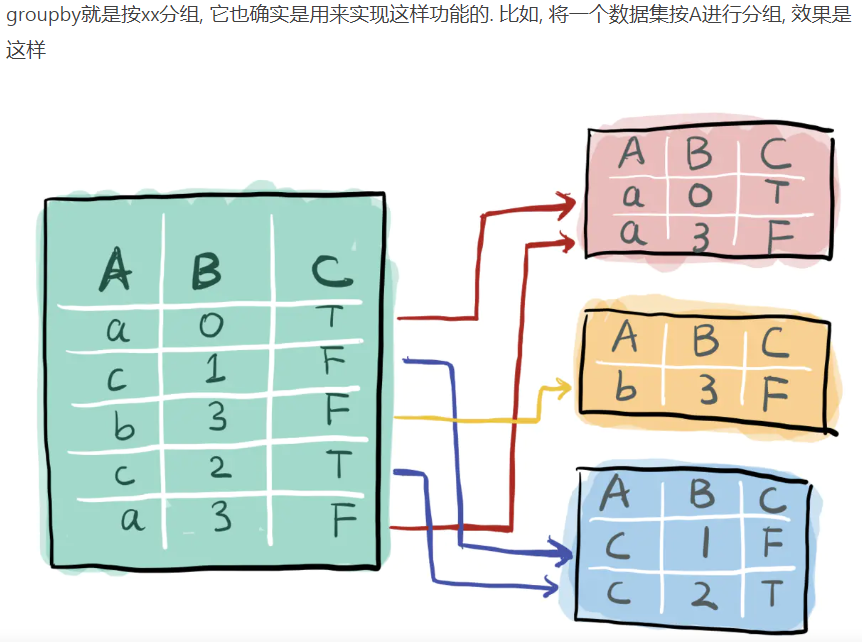

In [2]:
#载入数据
data = pd.read_csv('./train_data.csv')
data['Type'] = 'Train'
data_test = pd.read_csv('./test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data, data_test], ignore_index=True)
fea_cols = [col for col in data.columns]

In [3]:
data.head(5)
print(fea_cols)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0,Train
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0,Train
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0,Train
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0,Train
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0,Train


['ID', 'area', 'rentType', 'houseType', 'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration', 'communityName', 'city', 'region', 'plate', 'buildYear', 'saleSecHouseNum', 'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum', 'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'tradeTime', 'tradeMoney', 'Type']


# 统计特征
- 计算均值: gp = train.groupby(by)[fea].mean()
- 计算中位数: gp = train.groupby(by)[fea].median()
- 计算方差: gp = train.groupby(by)[fea].std()
- 计算最大值: gp = train.groupby(by)[fea].max()
- 计算最小值: gp = train.groupby(by)[fea].min()
- 计算出现次数: gp = train.groupby(by)[fea].size()
    

In [4]:
data.groupby('region')['tradeMoney'].agg({'tradeMoney_mean': 'mean', 'tradeMoney_std': 'std', 'tradeMoney_min': 'min', 'tradeMoney_max': 'max', 'tradeMoney_size': 'size'})

,tradeMoney_mean,tradeMoney_std,tradeMoney_min,tradeMoney_max,tradeMoney_size
region,,,,,
RG00001,5510.984443,11443.833327,300.0,370000.00,1157
RG00002,15059.614059,939696.139436,0.0,99999999.99,11437
RG00003,4197.520784,10658.358096,140.0,430000.00,4186
RG00004,3827.168317,6269.230098,0.0,350000.00,3333
RG00005,14162.471162,659981.771987,0.0,50000000.00,5739
RG00006,2034.853136,719.897210,140.0,9000.00,1961
RG00007,4867.021739,11359.939294,370.0,450000.00,1610
RG00008,7022.754400,9743.543487,600.0,320000.00,1250
RG00009,7718.173275,5707.374914,0.0,88000.00,681


In [5]:
data.groupby('subwayStationNum')['residentPopulation'].agg({'Population_mean': 'mean', 'Population_std': 'std', 'Population_min': 'min', 'Population_max': 'max', 'Population_size': 'size'})

,Population_mean,Population_std,Population_min,Population_max,Population_size
subwayStationNum,,,,,
0,100996.681271,12211.028388,92892,234932,913
1,234258.715407,39902.357233,134822,274232,3440
2,158075.449329,45344.109113,52091,223020,6187
3,203429.847287,75575.554422,49330,318387,5972
4,205805.577640,85094.817096,95192,301635,1932
5,451577.328540,365817.454470,97196,928198,4937
6,321826.195928,103811.329981,131744,428071,6778
7,232819.183137,78686.497547,111546,319860,3309
9,248647.000000,0.000000,248647,248647,1266


In [6]:
# 按照communityName分组计算面积的均值和方差
data.groupby('communityName')['area'].agg({'area_mean': 'mean', 'area_std': 'std', 'area_min': 'min', 'area_max': 'max', 'area_size': 'size'})

,area_mean,area_std,area_min,area_max,area_size
communityName,,,,,
XQ00001,100.170000,NaN,100.17,100.17,1
XQ00002,39.310000,0.000000,39.31,39.31,2
XQ00003,59.480000,NaN,59.48,59.48,1
XQ00004,120.030000,16.674373,108.89,139.20,3
XQ00005,29.000000,12.072403,7.10,48.69,13
...,...,...,...,...,...
XQ04232,52.079231,22.787946,10.00,80.32,13
XQ04233,23.027500,20.138281,12.00,53.21,4
XQ04234,113.363333,88.774537,59.93,215.84,3


In [7]:
# 特征拆分
# 将houseType转为'Room'，'Hall'，'Bath'
def Room(x):
    Room = int(x.split('室')[0])
    return Room
def Hall(x):
    Hall = int(x.split("室")[1].split("厅")[0])
    return Hall
def Bath(x):
    Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
    return Bath

data['Room'] = data['houseType'].apply(lambda x: Room(x))
data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
data['Bath'] = data['houseType'].apply(lambda x: Bath(x))

data.head(5)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney,Type,Room,Hall,Bath
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,111546,1124.0,284.0,0,2018/11/28,2000.0,Train,2,1,1
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,157552,701.0,22.0,1,2018/12/16,2000.0,Train,3,2,2
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,131744,57.0,20.0,1,2018/12/22,16000.0,Train,3,2,2
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,253337,888.0,279.0,9,2018/12/21,1600.0,Train,1,1,1
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,125309,2038.0,480.0,0,2018/11/18,2900.0,Train,3,2,3


In [8]:
#特征合并
# 合并部分配套设施特征
data['transportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / data['busStationNum'].mean()

# 交叉生成特征:特征之间交叉+ - * / 
data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)

data.head(5)

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,uv,lookNum,tradeTime,tradeMoney,Type,Room,Hall,Bath,transportNum,Room_Bath
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,284.0,0,2018/11/28,2000.0,Train,2,1,1,6.288606,0.666667
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,22.0,1,2018/12/16,2000.0,Train,3,2,2,2.724719,0.750000
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,20.0,1,2018/12/22,16000.0,Train,3,2,2,5.545913,0.750000
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,279.0,9,2018/12/21,1600.0,Train,1,1,1,4.557172,1.000000
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,480.0,0,2018/11/18,2900.0,Train,3,2,3,0.753217,1.000000


In [9]:
# # 聚类特征
# from sklearn.mixture import GaussianMixture  # 使用GaussianMixture做聚类特征

# gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
# y_pred = gmm.fit_predict(data)
# plt.scatter(data[:, 0], data[:, 1], c=y_pred)
# plt.show()

In [10]:
# 特征编码
from sklearn.preprocessing import LabelEncoder
data['communityName'] = LabelEncoder().fit_transform(data['communityName'])
data.head(5)

# 过大量级值取log平滑（针对线性模型有效）
# data[feature]=np.log1p(data[feature])

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,uv,lookNum,tradeTime,tradeMoney,Type,Room,Hall,Bath,transportNum,Room_Bath
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,50,SH,...,284.0,0,2018/11/28,2000.0,Train,2,1,1,6.288606,0.666667
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,129,SH,...,22.0,1,2018/12/16,2000.0,Train,3,2,2,2.724719,0.750000
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,178,SH,...,20.0,1,2018/12/22,16000.0,Train,3,2,2,5.545913,0.750000
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,312,SH,...,279.0,9,2018/12/21,1600.0,Train,1,1,1,4.557172,1.000000
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,1256,SH,...,480.0,0,2018/11/18,2900.0,Train,3,2,3,0.753217,1.000000


In [11]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('./train_data.csv')
test = pd.read_csv('./test_a.csv')
target_train = train.pop('tradeMoney')
print(train.head(5))
print(test.head(5))

          ID    area rentType houseType houseFloor  totalFloor houseToward  \
0  100309852   68.06     未知方式    2室1厅1卫          低          16        暂无数据   
1  100307942  125.55     未知方式    3室2厅2卫          中          14        暂无数据   
2  100307764  132.00     未知方式    3室2厅2卫          低          32        暂无数据   
3  100306518   57.00     未知方式    1室1厅1卫          中          17        暂无数据   
4  100305262  129.00     未知方式    3室2厅3卫          低           2        暂无数据   

  houseDecoration communityName city  ... tradeLandArea landTotalPrice  \
0              其他       XQ00051   SH  ...           0.0              0   
1              简装       XQ00130   SH  ...           0.0              0   
2              其他       XQ00179   SH  ...           0.0              0   
3              精装       XQ00313   SH  ...      108037.8      332760000   
4              毛坯       XQ01257   SH  ...           0.0              0   

  landMeanPrice  totalWorkers  newWorkers  residentPopulation      pv     uv  \
0     

## 特征合并

In [12]:
def newfeature(data):
    # 将houseType转为'Room'，'Hall'，'Bath'
    def Room(x):
        Room = int(x.split('室')[0])
        return Room
    def Hall(x):
        Hall = int(x.split("室")[1].split("厅")[0])
        return Hall
    def Bath(x):
        Bath = int(x.split("室")[1].split("厅")[1].split("卫")[0])
        return Bath

    data['Room'] = data['houseType'].apply(lambda x: Room(x))
    data['Hall'] = data['houseType'].apply(lambda x: Hall(x))
    data['Bath'] = data['houseType'].apply(lambda x: Bath(x))
    data['Room_Bath'] = (data['Bath']+1) / (data['Room']+1)
    # 填充租房类型
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] <= 1), 'rentType'] = '整租'
    # print(data.loc[(data['rentType']=='未知方式')&(data['Room_Bath']>1),'rentType'])
    data.loc[(data['rentType'] == '未知方式') & (data['Room_Bath'] > 1), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['Room'] > 1) & (data['area'] < 50), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] / data['Room'] < 20), 'rentType'] = '合租'
    # data.loc[(data['rentType']=='未知方式')&(data['area']>60),'rentType']='合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 50) & (data['Room'] == 2), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 2), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] <= 60) & (data['Room'] == 3), 'rentType'] = '合租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] > 60) & (data['Room'] == 3), 'rentType'] = '整租'
    data.loc[(data['rentType'] == '未知方式') & (data['area'] >= 100) & (data['Room'] > 3), 'rentType'] = '整租'

    # data.drop('Room_Bath', axis=1, inplace=True)
    # 提升0.0001
    def month(x):
        month = int(x.split('/')[1])
        return month
    # def day(x):
    #     day = int(x.split('/')[2])
    #     return day
    # 结果变差

    # 分割交易时间
    # data['year']=data['tradeTime'].apply(lambda x:year(x))
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    # data['day'] = data['tradeTime'].apply(lambda x: day(x))# 结果变差
    # data['pv/uv'] = data['pv'] / data['uv']
    # data['房间总数'] = data['室'] + data['厅'] + data['卫']

    # 合并部分配套设施特征
    data['transportNum'] = 5 * data['subwayStationNum'] / data['subwayStationNum'].mean() + data['busStationNum'] / \
                                                                                             data[
                                                                                                 'busStationNum'].mean()
    data['all_SchoolNum'] = 2 * data['interSchoolNum'] / data['interSchoolNum'].mean() + data['schoolNum'] / data[
        'schoolNum'].mean() \
                            + data['privateSchoolNum'] / data['privateSchoolNum'].mean()
    data['all_hospitalNum'] = 2 * data['hospitalNum'] / data['hospitalNum'].mean() + \
                              data['drugStoreNum'] / data['drugStoreNum'].mean()
    data['all_mall'] = data['mallNum'] / data['mallNum'].mean() + \
                       data['superMarketNum'] / data['superMarketNum'].mean()
    data['otherNum'] = data['gymNum'] / data['gymNum'].mean() + data['bankNum'] / data['bankNum'].mean() + \
                       data['shopNum'] / data['shopNum'].mean() + 2 * data['parkNum'] / data['parkNum'].mean()

    data.drop(['subwayStationNum', 'busStationNum',
               'interSchoolNum', 'schoolNum', 'privateSchoolNum',
               'hospitalNum', 'drugStoreNum', 'mallNum', 'superMarketNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum'],
              axis=1, inplace=True)
    # 提升0.0005
    
#     data['houseType_1sumcsu']=data['Bath'].map(lambda x:str(x))+data['month'].map(lambda x:str(x))
#     data['houseType_2sumcsu']=data['Bath'].map(lambda x:str(x))+data['communityName']
#     data['houseType_3sumcsu']=data['Bath'].map(lambda x:str(x))+data['plate']
    
    data.drop('houseType', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    
    data["area"] = data["area"].astype(int)

    # categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName','region', 'plate']
    categorical_feats = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate','cluster']

    return data#, categorical_feats

train = newfeature(train)
print(train.columns)
print(train.head(5))

Index(['ID', 'area', 'rentType', 'houseFloor', 'totalFloor', 'houseToward',
       'houseDecoration', 'communityName', 'city', 'region', 'plate',
       'buildYear', 'saleSecHouseNum', 'totalTradeMoney', 'totalTradeArea',
       'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'Room',
       'Hall', 'Bath', 'Room_Bath', 'month', 'transportNum', 'all_SchoolNum',
       'all_hospitalNum', 'all_mall', 'otherNum'],
      dtype='object')
          ID  area rentType houseFloor  totalFloor houseToward  \
0  100309852    68       整租          低          16        暂无数据   
1  100307942   125       整租          中          14        暂无数据   
2  100307764   132       整租          低          32        暂无数据  

## 计算统计特征

In [13]:
#计算统计特征
def featureCount(train,test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    def feature_count(data, features=[]):
        new_feature = 'count'
        for i in features:
            new_feature += '_' + i
        temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
        data = data.merge(temp, 'left', on=features)
        return data

    data = feature_count(data, ['communityName'])
    data = feature_count(data, ['buildYear'])
    data = feature_count(data, ['totalFloor'])
    data = feature_count(data, ['communityName', 'totalFloor'])
    data = feature_count(data, ['communityName', 'newWorkers'])
    data = feature_count(data, ['communityName', 'totalTradeMoney'])
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    return new_train, new_test
    
train, test = featureCount(train, test)
print(train.columns)
print(train.head(5))
print(test.head(5))

Index(['Bath', 'Hall', 'ID', 'Room', 'Room_Bath', 'all_SchoolNum',
       'all_hospitalNum', 'all_mall', 'area', 'bankNum', 'buildYear',
       'busStationNum', 'city', 'communityName', 'drugStoreNum', 'gymNum',
       'hospitalNum', 'houseDecoration', 'houseFloor', 'houseToward',
       'houseType', 'interSchoolNum', 'landMeanPrice', 'landTotalPrice',
       'lookNum', 'mallNum', 'month', 'newWorkers', 'otherNum', 'parkNum',
       'plate', 'privateSchoolNum', 'pv', 'region', 'remainNewNum', 'rentType',
       'residentPopulation', 'saleSecHouseNum', 'schoolNum', 'shopNum',
       'subwayStationNum', 'superMarketNum', 'supplyLandArea', 'supplyLandNum',
       'supplyNewNum', 'totalFloor', 'totalNewTradeArea', 'totalNewTradeMoney',
       'totalTradeArea', 'totalTradeMoney', 'totalWorkers', 'tradeLandArea',
       'tradeLandNum', 'tradeMeanPrice', 'tradeNewMeanPrice', 'tradeNewNum',
       'tradeSecNum', 'tradeTime', 'transportNum', 'uv', 'count_communityName',
       'count_buildYear'

## groupby方法生成统计特征

In [14]:
#groupby生成统计特征：mean,std等

def groupby(train, test):
    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    temp = data.groupby('communityName')['area'].agg({'com_area_mean': 'mean', 'com_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')
    
    data['price_per_area'] = data.tradeMeanPrice / data.area * 100
    temp = data.groupby('communityName')['price_per_area'].agg({'comm_price_mean': 'mean', 'comm_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='communityName', how='left')

    temp = data.groupby('plate')['price_per_area'].agg({'plate_price_mean': 'mean', 'plate_price_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    data.drop('price_per_area', axis=1, inplace=True)

    temp = data.groupby('plate')['area'].agg({'plate_area_mean': 'mean', 'plate_area_std': 'std'})
    temp.fillna(0, inplace=True)
    data = data.merge(temp, on='plate', how='left')
    
#     temp = data.groupby(['plate'])['buildYear'].agg({'plate_year_mean': 'mean', 'plate_year_std': 'std'})
#     data = data.merge(temp, on='plate', how='left')
#     data.plate_year_mean = data.plate_year_mean.astype('int')
#     data['comm_plate_year_diff'] = data.buildYear - data.plate_year_mean
#     data.drop('plate_year_mean', axis=1, inplace=True)

    temp = data.groupby('plate')['transportNum'].agg('sum').reset_index(name='plate_trainsportNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['transportNum'].agg('sum').reset_index(name='com_trainsportNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['trainsportNum_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                           data['com_trainsportNum'], data['plate_trainsportNum']))
    data = data.drop(['com_trainsportNum', 'plate_trainsportNum'], axis=1)

    temp = data.groupby('plate')['all_SchoolNum'].agg('sum').reset_index(name='plate_all_SchoolNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['all_SchoolNum'].agg('sum').reset_index(name='com_all_SchoolNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data = data.drop(['com_all_SchoolNum', 'plate_all_SchoolNum'], axis=1)

    temp = data.groupby(['communityName', 'plate'])['all_mall'].agg('sum').reset_index(name='com_all_mall')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')

    temp = data.groupby('plate')['otherNum'].agg('sum').reset_index(name='plate_otherNum')
    data = data.merge(temp, on='plate', how='left')
    temp = data.groupby(['communityName', 'plate'])['otherNum'].agg('sum').reset_index(name='com_otherNum')
    data = data.merge(temp, on=['communityName', 'plate'], how='left')
    data['other_ratio'] = list(map(lambda x, y: round(x / y, 3) if y != 0 else -1,
                                   data['com_otherNum'], data['plate_otherNum']))
    data = data.drop(['com_otherNum', 'plate_otherNum'], axis=1)

    temp = data.groupby(['month', 'communityName']).size().reset_index(name='communityName_saleNum')
    data = data.merge(temp, on=['month', 'communityName'], how='left')
    temp = data.groupby(['month', 'plate']).size().reset_index(name='plate_saleNum')
    data = data.merge(temp, on=['month', 'plate'], how='left')

    data['sale_ratio'] = round((data.communityName_saleNum + 1) / (data.plate_saleNum + 1), 3)
    data['sale_newworker_differ'] = 3 * data.plate_saleNum - data.newWorkers
    data.drop(['communityName_saleNum', 'plate_saleNum'], axis=1, inplace=True)

    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    return new_train, new_test

train, test = groupby(train, test)
# print(train.columns)
print(train.head(5))
print(test.head(5))

   Bath  Hall         ID  Room  Room_Bath  all_SchoolNum  all_hospitalNum  \
0   1.0   1.0  100309852   2.0   0.666667       0.740007         0.671941   
1   2.0   2.0  100307942   3.0   0.750000       0.539097         0.931651   
2   2.0   2.0  100307764   3.0   0.750000       2.538138         1.808056   
3   1.0   1.0  100306518   1.0   1.000000       4.058857         5.150448   
4   3.0   2.0  100305262   3.0   1.000000       0.311017         0.363594   

   all_mall   area  bankNum  ... comm_price_std  plate_price_mean  \
0  0.743322   68.0      NaN  ...   47974.795412     125624.205625   
1  1.251852  125.0      NaN  ...   11811.541675      58295.875466   
2  0.999120  132.0      NaN  ...   84009.401900      89724.845574   
3  1.736086   57.0      NaN  ...    6336.877320      27432.630798   
4  0.728222  129.0      NaN  ...   10548.340105      89588.027220   

  plate_price_std  plate_area_mean  plate_area_std  trainsportNum_ratio  \
0   109845.733157        62.548764       41.059

In [16]:
train_drop = train.drop(['drugStoreNum','gymNum','hospitalNum','houseType','interSchoolNum',
                         'mallNum','parkNum','privateSchoolNum','schoolNum',
                         'shopNum','subwayStationNum','superMarketNum','tradeTime'],
              axis=1, inplace=True)
train.to_csv('./train_data(featured).csv')

In [ ]:
train = pd.read_csv('./train_data(featured).csv')

## 聚类方法

In [ ]:
#聚类
def cluster(train, test):
    from sklearn.mixture import GaussianMixture

    train['data_type'] = 0
    test['data_type'] = 1
    data = pd.concat([train, test], axis=0, join='outer')
    col = ['totalFloor',
           'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',

           'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
           'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',

           'landTotalPrice', 'landMeanPrice', 'totalWorkers',
           'newWorkers', 'residentPopulation', 'lookNum',
           'transportNum',
           'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']

    # EM
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    data['cluster']= pd.DataFrame(gmm.fit_predict(data[col]))


    col1 = ['totalFloor','houseDecoration', 'communityName', 'region', 'plate', 'buildYear']
    col2 = ['tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
            'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
            'landTotalPrice', 'landMeanPrice', 'totalWorkers',
            'newWorkers', 'residentPopulation', 'lookNum',
            'transportNum',
            'all_SchoolNum', 'all_hospitalNum', 'all_mall', 'otherNum']
    for feature1 in col1:
        for feature2 in col2:
        
            temp = data.groupby(['cluster',feature1])[feature2].agg('mean').reset_index(name=feature2+'_'+feature1+'_cluster_mean')
            temp.fillna(0, inplace=True)
            
            data = data.merge(temp, on=['cluster', feature1], how='left')
    
    new_train = data[data['data_type'] == 0]
    new_test = data[data['data_type'] == 1]
    new_train.drop('data_type', axis=1, inplace=True)
    new_test.drop(['data_type'], axis=1, inplace=True)
    
    return new_train, new_test

# train, test = cluster(train, test)   

## log平滑

In [ ]:
# 过大量级值取log平滑（针对线性模型有效）
big_num_cols = ['totalTradeMoney','totalTradeArea','tradeMeanPrice','totalNewTradeMoney', 'totalNewTradeArea',
                'tradeNewMeanPrice','remainNewNum', 'supplyNewNum', 'supplyLandArea',
                'tradeLandArea','landTotalPrice','landMeanPrice','totalWorkers','newWorkers',
                'residentPopulation','pv','uv']
for col in big_num_cols:
        train[col] = train[col].map(lambda x: np.log1p(x))
        test[col] = test[col].map(lambda x: np.log1p(x))
        

In [24]:
train = pd.read_csv('./train_data(cleared).csv')
target_train = pd.read_csv('./train_data(featured).csv')

In [29]:
#对比特征工程前后线性模型结果情况
# test = test.fillna(0)
# # Lasso回归
# from sklearn.linear_model import Lasso
# lasso = Lasso(alpha=0.1)
# lasso.fit(train, target_train)
# #预测测试集和训练集结果
# y_pred_train = lasso.predict(train)
# y_pred_test = lasso.predict(test)

# #对比结果
# from sklearn.metrics import r2_score
# score_train = r2_score(y_pred_train,target_train)
# print("训练集结果：",score_train)
# score_test = r2_score(y_pred_test, target_test)
# print("测试集结果：",score_test)

# 特征选择

In [32]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
#读取数据
train = pd.read_csv('./train_data(featured).csv')
test = pd.read_csv('./test_a.csv')

# target_train = train.pop('tradeMoney')
# target_test = test.pop('tradeMoney')

## 相关系数法

In [33]:
#相关系数法特征选择
from sklearn.feature_selection import SelectKBest

print(train.shape)

sk=SelectKBest(k=150)
new_train=sk.fit_transform(train,target_train)
print(new_train.shape)

# 获取对应列索引
select_columns=sk.get_support(indices = True)
# print(select_columns)

# 获取对应列名
# print(test.columns[select_columns])
select_columns_name=test.columns[select_columns]
new_test=test[select_columns_name]
print(new_test.shape)
# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

(41440, 67)


ValueError: could not convert string to float: '暂无信息'

## Wrapper

In [ ]:
# Wrapper

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=160)
rfe.fit(train,target_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=40, step=1, verbose=0)




select_columns = [f for f, s in zip(train.columns, rfe.support_) if s]
print(select_columns)
new_train = train[select_columns]
new_test = test[select_columns]

# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

## Embedded
### 基于惩罚项的特征选择法
### Lasso(l1)和Ridge(l2)

In [ ]:
# Embedded
# 基于惩罚项的特征选择法
# Lasso(l1)和Ridge(l2)

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=5)
ridge.fit(train,target_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

# 特征系数排序
coefSort = ridge.coef_.argsort()
print(coefSort)


# 特征系数
featureCoefSore=ridge.coef_[coefSort]
print(featureCoefSore)


select_columns = [f for f, s in zip(train.columns, featureCoefSore) if abs(s)> 0.0000005 ] 
# 选择绝对值大于0.0000005的特征

new_train = train[select_columns]
new_test = test[select_columns]
# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)

### 基于树模型的特征选择法
### 随机森林 平均不纯度减少（mean decrease impurity

In [ ]:
# Embedded
# 基于树模型的特征选择法
# 随机森林 平均不纯度减少（mean decrease impurity


from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
# 训练随机森林模型，并通过feature_importances_属性获取每个特征的重要性分数。rf = RandomForestRegressor()
rf.fit(train,target_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), train.columns),
             reverse=True))

select_columns = [f for f, s in zip(train.columns, rf.feature_importances_) if abs(s)> 0.00005 ] 
# 选择绝对值大于0.00005的特征

new_train = train[select_columns]
new_test = test[select_columns]

# Lasso回归
from sklearn.linear_model import Lasso

lasso=Lasso(alpha=0.1)
lasso.fit(new_train,target_train)
#预测测试集和训练集结果
y_pred_train=lasso.predict(new_train)

y_pred_test=lasso.predict(new_test)

#对比结果
from sklearn.metrics import r2_score
score_train=r2_score(y_pred_train,target_train)
print("训练集结果：",score_train)
score_test=r2_score(y_pred_test, target_test)
print("测试集结果：",score_test)